In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Loading and Inspecting the Dataset
First, let's load the dataset and take a preliminary look at its structure.

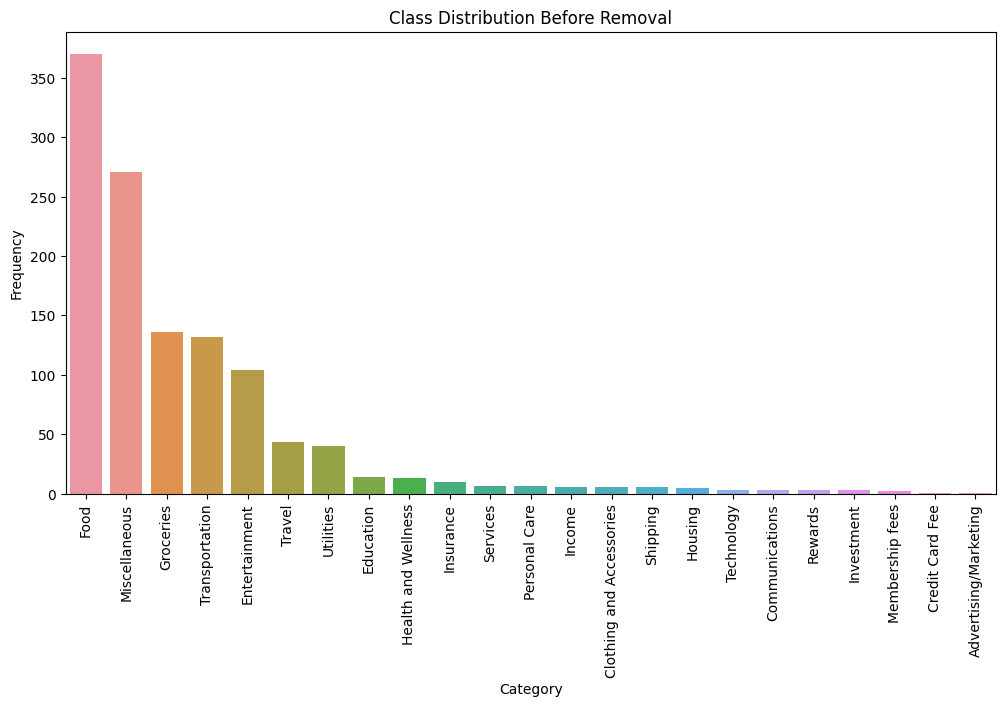

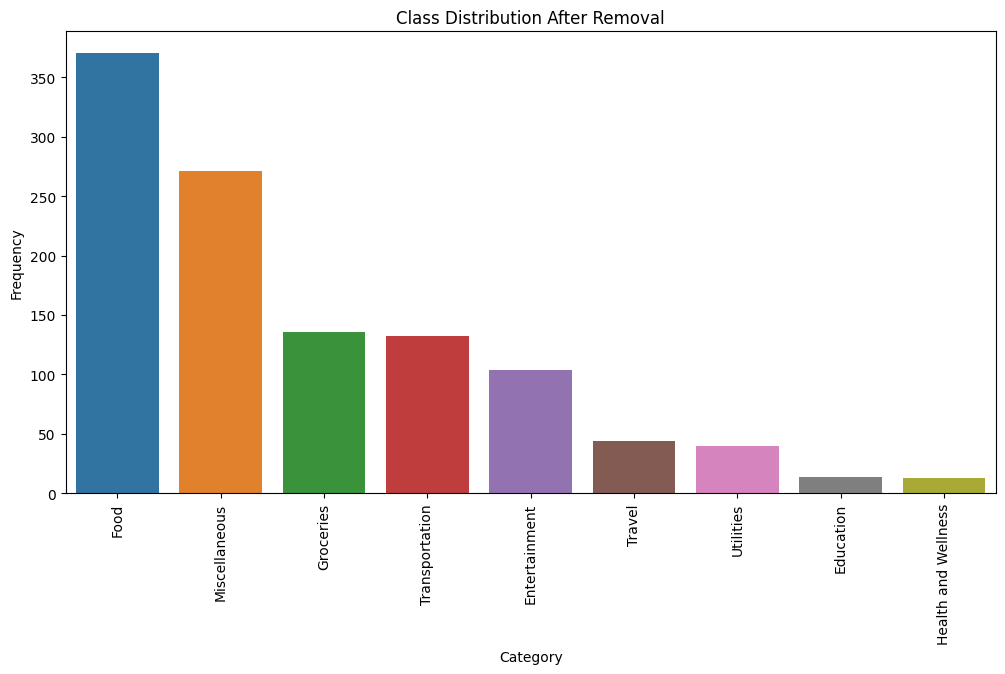

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/kaggle/input/amex-categorized/Amex Categorized Raw.csv'  # Update this to your actual file path
data = pd.read_csv(file_path)

# Visualizing class distribution
plt.figure(figsize=(12, 6))
class_counts = data['Category'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.title('Class Distribution Before Removal')
plt.show()

# Remove classes with fewer than N observations
N = 10  # Threshold for removal, adjust based on your dataset
data = data[data.groupby('Category')['Category'].transform('count') > N]

# Visualize class distribution after removal
plt.figure(figsize=(12, 6))
class_counts_after = data['Category'].value_counts()
sns.barplot(x=class_counts_after.index, y=class_counts_after.values)
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.title('Class Distribution After Removal')
plt.show()




## Preprocessing and Splitting the Dataset
We'll preprocess the dataset by splitting into train and test set as well as use stratified sampling.

In [15]:
from sklearn.model_selection import train_test_split

X = data['Description']
y = data['Category']

# Splitting the dataset (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Setting Up the Pipeline and Grid Search CV for Hyperparameter Tuning
We'll use TF-IDF for text processing and feature extraction. Random Forest classifier with k-fold cross validation to categorize transactions based on their processed descriptions.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'tfidf__max_features': [None, 5000, 10000]
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_features': None}
Best score: 0.7230043451272501


## Evaluation
Evaluate the model's performance using accuracy, precision, recall, f1 score, and the confusion matrix.

Classification Report:
                     precision    recall  f1-score   support

          Education       0.14      1.00      0.24         3
      Entertainment       0.88      0.33      0.48        21
               Food       0.75      0.86      0.81        74
          Groceries       0.82      0.85      0.84        27
Health and Wellness       0.00      0.00      0.00         3
      Miscellaneous       0.88      0.81      0.85        54
     Transportation       0.82      0.69      0.75        26
             Travel       0.67      0.44      0.53         9
          Utilities       0.50      0.25      0.33         8

           accuracy                           0.73       225
          macro avg       0.61      0.58      0.54       225
       weighted avg       0.78      0.73      0.74       225

Accuracy: 0.7333


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


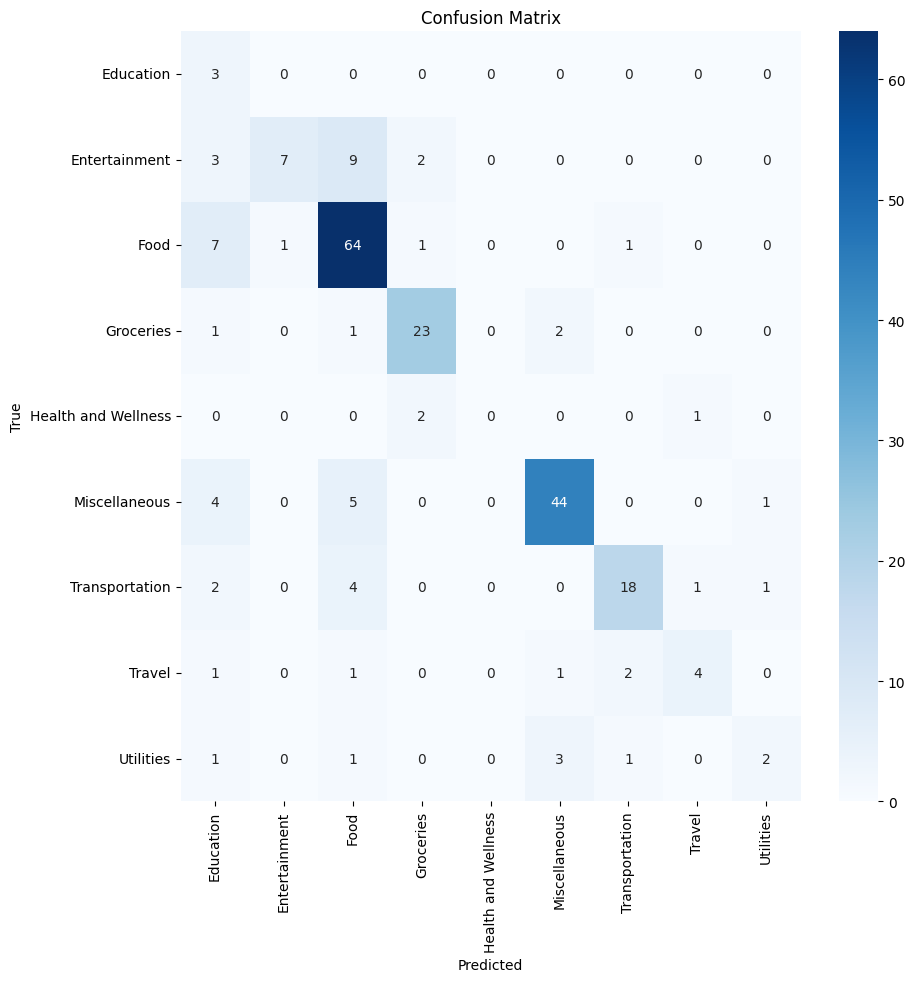

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = grid_search.predict(X_test)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Display Test Set With Predictions

In [18]:
# Create a DataFrame with actual and predicted categories
results_df = pd.DataFrame({'Actual Category': y_test, 'Predicted Category': y_pred, 'Description': X_test})

# Reset index to make it more readable
results_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(results_df.head(20))  # Show the first 20 results; adjust as needed


   Actual Category Predicted Category                     Description
0             Food               Food  Grubhub (Momofactory New York)
1   Transportation     Transportation               American Airlines
2             Food               Food     grubhubrandyspizza new york
3        Utilities          Utilities                 Comcast Chicago
4    Entertainment      Entertainment               Dram Shop Chicago
5             Food               Food                subway champaign
6    Entertainment          Groceries          Kingston Mines Chicago
7    Miscellaneous      Miscellaneous                     Description
8    Entertainment      Entertainment  SeatGeek Tickets San Francisco
9             Food          Groceries            kameya ramen chicago
10   Miscellaneous      Miscellaneous        Mobile payment thank you
11   Miscellaneous      Miscellaneous                     Description
12       Groceries          Groceries        safeway store washington
13       Groceries  